In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy.linalg as LA
import timeit
from sklearn.metrics import mean_squared_error
import math
import spgl1 as spgl1
from sklearn.linear_model import orthogonal_mp
import pywt
from data_matrices import *
from sys import getsizeof
#import DLIPsim as dlip
import inspect
from pprint import pprint
import warnings
from cs_utils import *
warnings.filterwarnings('ignore')
from decimal import Decimal


In [3]:
rugosity = 0.1
target='elliptical'
SNR = 1e4 # 0dB
#1e4#40 #dB
SNR_dB = int(10*np.log10(SNR))
print(SNR_dB)
c = 0.3 #0.299792458 # Velocidad de la luz (x 1e9 m/s)
fc = 15 # Frecuencia Central(GHz)
BW = 0.6 # Ancho de banda(GHz)
Ls = 1.2 # 4 # 0.6 # Longitud del riel (m)
Ro = 0 # Constante debido al delay de los cables(m)
theta = 90 # Angulo azimuth de vision de la imagen final(grados sexagesimales E [0-90])

40


40 40
150 248 256
40 40 16 16
(256,)


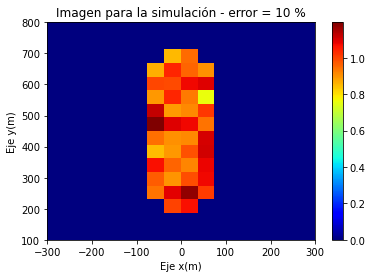

In [4]:
#'elliptical'#'ROJ'#'elliptical'#'ROJ'#'UNI'#'T'#'ROJ'#'UNI'#'T'#'ROJ'
I_t, R_t, x_c,y_c, N_r, N_c, w, h,dw, dh, str_target = SelectTarget(target,rugosity)
# Hallando el Np a partir de los pasos
dp=c/(4.1*fc*np.sin(theta*np.pi/180)) # paso del riel para un angulo de vision de 180°
Np=int(Ls/dp)+1 # Numero de pasos del riel
if Np%2!=0:
    Np+=1   # Para que el numero de pasos sea par
# Hallando el Nf en funcion a la distancia máxima deseada
r_r=c/(2*BW) # resolucion en rango
Nf=150#int(h/r_r) #+1 #Numero de frecuencias
print(Nf,Np,N_r*N_c)
print(dw, dh, N_r, N_c)
print(I_t.shape)

(256,) (16,) (16, 1)


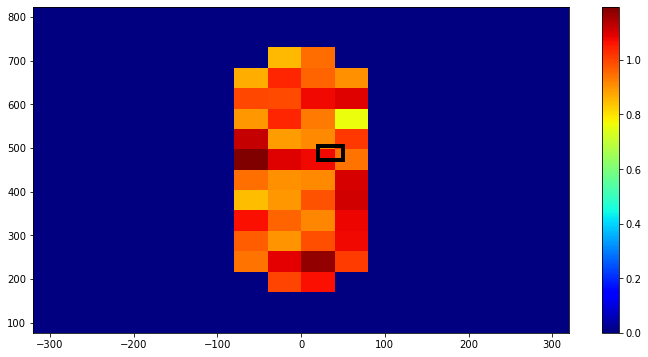

In [5]:
print(I_t.shape, x_c.shape, y_c.shape)
I_sim = I_t.reshape(N_r,N_c)
rectangle = Rectangle(( x_c[8],  y_c[8]), 30, 30,
                      alpha=1, facecolor='black',fill=None,linewidth=4)
fig, ax = plt.subplots(figsize=(12,6))
clrs = ax.pcolormesh(x_c,y_c,I_sim,cmap='jet')
cb = plt.colorbar(clrs,ax=ax)
#ax.text(x_c[8], y_c[8], 'X', fontsize = 22,color='black')
ax.add_patch(rectangle)

In [6]:
vmin, vmax = -100, -20 #dB
Lx,Ly,dx,dy = w,h,dw,dh # Dimensiones de la imagen
x_min, x_max= [-(Lx+dx)/2, (Lx+dx)/2]
y_min, y_max= [0-dy/2,Ly+dy/2]
extent = [x_min,x_max,y_min,y_max]
print(Lx,Ly,dx,dy)
print(Lx/dx+1, Ly/dy+1)
print(extent)
prm={'c':c,'fc':fc,'BW':BW,'Ls':Ls,'Ro':Ro,'theta':theta,'Np':Np,'Nf':Nf,
       'w':w,'h':h,'dw':dw,'dh':dh}

640 640 40 40
17.0 17.0
[-340.0, 340.0, -20.0, 660.0]


In [7]:
fi=fc-BW/2 # Frecuencia inferior(GHz)
fs=fc+BW/2 # Frecuencia superior(GHz)
# Cálculo de las resoluciones
rr_r=c/(2*BW) # Resolución en rango
rr_a=(c/(2*Ls*fc))*R_t.T[1].max() # Resolución en azimuth
#-----------------VERIFICACIÓN DE CONDICIONES------------------------
# Rango máximo
R_max=Nf*c/(2*BW)
# Paso del riel máximo
dx_max=c/(fc*4*np.sin(theta*np.pi/180)) # Theta en grados sexagesimales
print("------------------------------------------------------")
print("--------------INFORMACIÓN IMPORTANTE------------------")
print("------------------------------------------------------")
print("- Resolución en rango(m) : ", rr_r)
print("- Resolución en azimuth(m): ", rr_a)
print("------------------------------------------------------")
print("- Rango máximo permitido(m): ", R_max)
print("------------------------------------------------------")
print("______¿Se cumplen las siguientes condiciones?_________")
print("Rango máximo del target <= rango máximo?: ", R_t.T[1].max()<=R_max) # Ponerle un try-except
print("Paso del riel <= paso máximo?: ", dp<=dx_max) # Evita el aliasing en el eje de azimuth
print("------------------------------------------------------")


------------------------------------------------------
--------------INFORMACIÓN IMPORTANTE------------------
------------------------------------------------------
- Resolución en rango(m) :  0.25
- Resolución en azimuth(m):  [6.66666667]
------------------------------------------------------
- Rango máximo permitido(m):  37.5
------------------------------------------------------
______¿Se cumplen las siguientes condiciones?_________
Rango máximo del target <= rango máximo?:  [False]
Paso del riel <= paso máximo?:  True
------------------------------------------------------


In [8]:
#----------------OBTENCIÓN DE la historia DE FASE----------------------
#start_time = timeit.default_timer()
Ski = get_phaseH(prm,I_t,R_t)
#print("Tiempo del procesamiento(IP): ",timeit.default_timer() - start_time," s")
data = {'Ski':Ski, 'dp':dp, 'fi':fi, 'fs':fs, 'R_max':R_max}
module_sim = abs(I_t).reshape(N_r,N_c)#20*np.log10(abs(I_t)).reshape(N_r,N_c)#abs(I_t).reshape(N_r,N_c)#
phase_sim = np.zeros(I_t.shape).reshape(N_r,N_c)
#I_sim = I_t.reshape(N_r,N_c)
print('Phase history: ', Ski.shape)

(150,) (248,)
Phase history:  (248, 150)


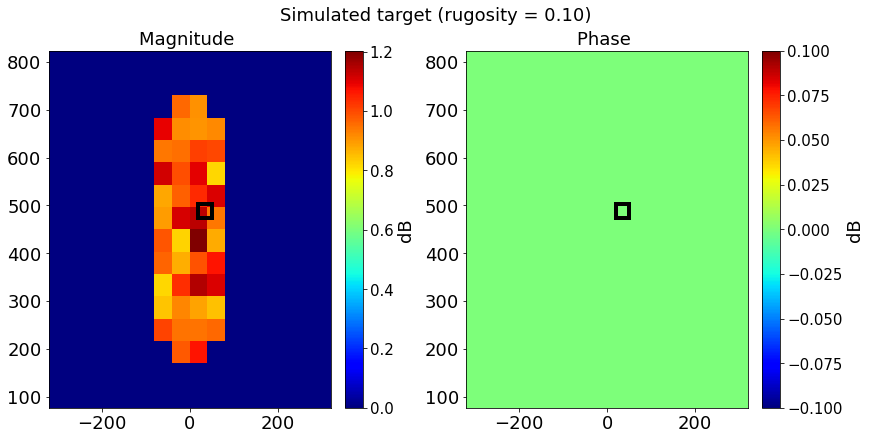

In [24]:
fontsize=18
rectangle = Rectangle(( x_c[8],  y_c[8]), 30, 30,
                      alpha=1, facecolor='black',fill=None,linewidth=4)
rectangle2 = Rectangle(( x_c[8],  y_c[8]), 30, 30,
                      alpha=1, facecolor='black',fill=None,linewidth=4)
fig, ax = plt.subplots(1,2,figsize=(12,6), layout='constrained')#,sharey=True)
clrs1 = ax[0].pcolormesh(x_c, y_c,np.abs(I_sim) ,cmap='jet')
box=ax[0].get_position()
cb1=plt.colorbar(clrs1,ax=ax[0])#,location='left'
ax[0].set_title('Magnitude ' ,fontsize=fontsize)
cb1.set_label(r'dB', fontsize=fontsize)
cb1.ax.tick_params(labelsize=fontsize-3)
ax[0].xaxis.set_tick_params(labelsize=fontsize)
ax[0].yaxis.set_tick_params(labelsize=fontsize)
ax[0].add_patch(rectangle)
clrs2 = ax[1].pcolormesh(x_c, y_c,np.angle(I_sim) ,cmap='jet')
box=ax[1].get_position()
cb2=plt.colorbar(clrs2,ax=ax[1])
ax[1].set_title('Phase ' ,fontsize=fontsize)
cb2.set_label(r'dB', fontsize=fontsize)
cb2.ax.tick_params(labelsize=fontsize-3)
ax[1].xaxis.set_tick_params(labelsize=fontsize)
ax[1].yaxis.set_tick_params(labelsize=fontsize)
ax[1].add_patch(rectangle2)
fig.suptitle('Simulated target (rugosity = %.2f)' % rugosity,fontsize=fontsize)
plt.savefig('simulated-target-with-displacement-region-marked.png' ,bbox_inches='tight')


In [12]:
fi = data['fi']
fs = data['fs']
riel_p = np.linspace(-Ls/2, Ls/2, Np) # Vector de posiciones
f = np.linspace(fi, fs, Nf) # Vector de frecuencias
ks = 2*np.pi*f/c # Range domain wavenumber
r_c=np.array([(i,j) for j in y_c for i in x_c])
print(SNR_dB)

40


### Determining the noise level from SNR and phase history module

In [9]:
D2 = np.linalg.norm(Ski)**2/(Ski.shape[0]*Ski.shape[1])
n0 = np.sqrt(D2/SNR)
print(SNR)
print(n0)
print(Ski.shape)
fils,cols = Ski.shape
por = 40
per=por/100
R_t = 0
numRealizations = 100
mode = 'periodization'
#['zero', 'constant', 'symmetric', 'periodic', 'smooth', 'periodization', 'reflect', 'antisymmetric', 'antireflect']
wavelet = 'db2'

10000.0
0.06610684725163021
(248, 150)


In [25]:
xf_list = []
x_temp = np.zeros((len(y_c),len(x_c)),dtype=complex)
Im_list = []
for i in range(numRealizations):
    noise_re = np.random.rand(fils,cols)
    noise_im = np.random.rand(fils,cols)
    noise = n0*(noise_re+1j*noise_im)/np.sqrt(2)
    Ski_noisy = Ski + noise
    A_rand, S1_rand = UnderSample(r_c,riel_p,R_t,Nf,Np,per,Ski_noisy,f)
    b_rand = S1_rand.flatten()
    N = A_rand.shape[1]#b_rand.shape[0]
    Psi = WaveletMatrix(wavelet,N)
    ar = Psi.T@Psi
    ar[ar<1e-15]=0
    sigma   = n0
    N = A_rand.shape[1]
    Psi = WaveletMatrix(wavelet,N)
    A_i = np.imag(np.dot(A_rand,Psi))
    A_r = np.real(np.dot(A_rand,Psi))
    b_i = np.imag(b_rand)
    b_r = np.real(b_rand)
    Aug = np.block([[A_r, -A_i],[A_i, A_r]])
    baug = np.concatenate((b_r,b_i),axis=0)
    xaug,raug,gaug,info = spgl1.spg_bpdn(Aug, baug.flatten(), sigma)
    x = xaug[0:N] + 1j*xaug[N:]
    x_mp = Psi@x
    x_f = np.reshape(x_mp,(len(y_c),len(x_c)))
    xf_list.append(x_f)
    if i>=1:
        Im_prod = np.multiply(x_temp,np.conjugate(x_f))[8,8]   
        Im_list.append(Im_prod)
    x_temp = x_f
    #del 

In [1]:
Im_list = np.array(Im_list)
phase_list = np.angle(Im_list)

NameError: name 'np' is not defined

In [27]:
phase_list

array([ 8.76026110e-04, -3.90788576e-05, -5.97163098e-04,  7.11290594e-04,
       -9.45620637e-04, -2.39033770e-05, -1.55821452e-04,  2.04864174e-04,
        1.05908148e-03, -1.07294503e-03,  2.28081617e-04,  1.53804554e-04,
       -2.16815702e-04, -1.22097158e-04, -6.70878579e-05,  4.05950559e-04,
       -1.14814755e-04,  2.26025113e-04, -6.40673039e-04,  2.95400083e-04,
        7.48448661e-05,  5.04902658e-04, -1.00674939e-04,  2.17822174e-04,
       -6.35987601e-04,  1.17564557e-04,  3.16843243e-06,  2.66787547e-04,
       -1.77286287e-05, -3.17523849e-04, -1.56144693e-05,  2.23764316e-05,
       -1.57196919e-04,  5.22108729e-04, -5.59895810e-04,  4.38508966e-04,
       -2.35085153e-04,  6.76695403e-04, -2.24431051e-04, -2.42325722e-04,
       -7.10884159e-05,  3.80675728e-04, -7.68269464e-04,  4.84609653e-04,
        7.12818732e-04, -7.95295085e-04, -1.44063371e-04, -1.96212004e-04,
        6.32190548e-04, -8.08993590e-04,  8.15252562e-04,  1.68174988e-04,
       -3.63947976e-04,  

In [28]:
lambd = c/fc
sigma_rad = np.std(phase_list)
sigma_deg = (180/np.pi)*sigma_rad
sigma_delta_r = sigma_rad*(lambd/4*np.pi)
delta_r = np.array(phase_list)*(lambd/4*np.pi)
str_std = '%.2E' % Decimal(sigma_delta_r)

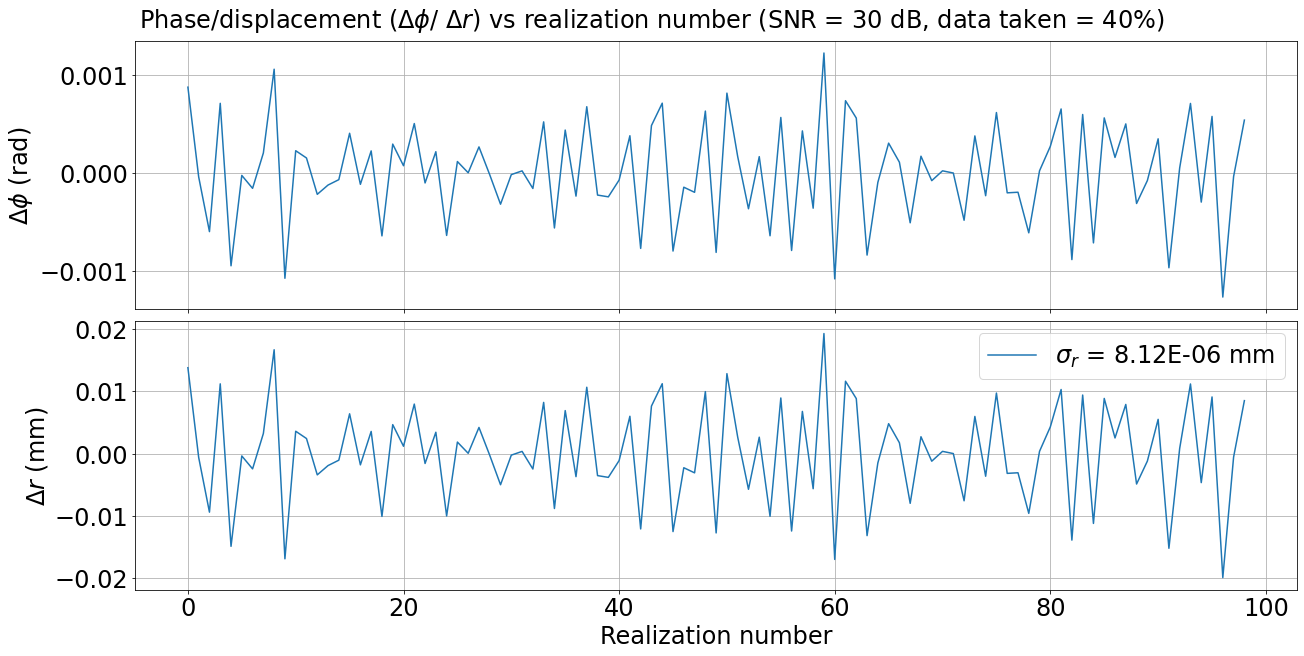

In [29]:
fontsize=24
fig, ax = plt.subplots(2,1,figsize=(18,9), layout='constrained',sharex=True)
ax[0].plot(phase_list)
ax[0].xaxis.set_tick_params(labelsize=fontsize)
ax[0].yaxis.set_tick_params(labelsize=fontsize)
ax[0].set_ylabel(r'$\Delta \phi$ (rad)',fontsize=fontsize)
ax[0].grid()
ax[1].plot(delta_r*1000,label=r'$\sigma_r$ = %s mm' % str_std)
ax[1].xaxis.set_tick_params(labelsize=fontsize)
ax[1].yaxis.set_tick_params(labelsize=fontsize)
ax[1].set_ylabel(r'$\Delta r$ (mm)',fontsize=fontsize)
ax[1].set_xlabel(r'Realization number',fontsize=fontsize)
ax[1].grid()
ax[1].legend(fontsize=fontsize,loc='best')
fig.suptitle(r'Phase/displacement ($\Delta \phi$/ $\Delta r$) vs realization number (SNR = %d dB, data taken = %d%%)' % (SNR_dB,por) ,fontsize=fontsize)
plt.savefig('displacement-variance-SNR=%d-dB-percentage=%d.png' % (SNR_dB,por),bbox_inches='tight')

In [10]:
#print(lambd)
#print(delta_r)
porcentajes = np.linspace(5,100,20)
percentages = porcentajes/100
#print(porcentajes)
print(percentages)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]


In [28]:
#print(per)
for i,per in enumerate(percentages):
    print(i,per,porcentajes[i])

0 0.05 5.0
1 0.1 10.0
2 0.15 15.0
3 0.2 20.0
4 0.25 25.0
5 0.3 30.0
6 0.35 35.0
7 0.4 40.0
8 0.45 45.0
9 0.5 50.0
10 0.55 55.0
11 0.6 60.0
12 0.65 65.0
13 0.7 70.0
14 0.75 75.0
15 0.8 80.0
16 0.85 85.0
17 0.9 90.0
18 0.95 95.0
19 1.0 100.0


In [ ]:
import gc
lambd = c/fc
numRealizations = 1#100
sigma_list = []
fils, cols = Ski.shape
for j,per in enumerate(percentages):
    print("************************************")
    print("Percentage: %2d %%" % porcentajes[j])
    xf_list = []
    x_temp = np.zeros((len(y_c),len(x_c)),dtype=complex)
    Im_list = []
    for i in range(numRealizations):
        print('Realization number',i)
        noise_re = np.random.rand(fils,cols)
        noise_im = np.random.rand(fils,cols)
        noise = n0*(noise_re+1j*noise_im)/np.sqrt(2)
        Ski_noisy = Ski + noise
        A_rand, S1_rand = UnderSample(r_c,riel_p,R_t,Nf,Np,per,Ski_noisy,f)
        b_rand = S1_rand.flatten()
        N = A_rand.shape[1]#b_rand.shape[0]
        Psi = WaveletMatrix(wavelet,N)
        #ar = Psi.T@Psi
        #ar[ar<1e-15]=0
        sigma   = n0
        N = A_rand.shape[1]
        Psi = WaveletMatrix(wavelet,N)
        A_i = np.imag(np.dot(A_rand,Psi))
        A_r = np.real(np.dot(A_rand,Psi))
        b_i = np.imag(b_rand)
        b_r = np.real(b_rand)
        Aug = np.block([[A_r, -A_i],[A_i, A_r]])
        baug = np.concatenate((b_r,b_i),axis=0)
        xaug,raug,gaug,info = spgl1.spg_bpdn(Aug, baug.flatten(), sigma)
        x = xaug[0:N] + 1j*xaug[N:]
        x_mp = Psi@x
        x_f = np.reshape(x_mp,(len(y_c),len(x_c)))
        xf_list.append(x_f)
        if i>=1:
            Im_prod_full = np.multiply(x_temp,np.conjugate(x_f))
            Im_prod = Im_prod_full[8,8]   
            Im_list.append(Im_prod)
        x_temp = x_f
    ##############################
    del xaug,raug,gaug,info
    del Aug,baug, b_i, b_r, A_r, Psi
    del A_rand, b_rand, S1_rand, Ski_noisy
    del noise, noise_re, noise_im
    del x_f, x, x_mp
    gc.collect()
    ##############################
    Im_list = np.array(Im_list)
    phase_list = np.angle(Im_list)
    sigma_rad = np.std(phase_list)
    sigma_deg = (180/np.pi)*sigma_rad
    sigma_delta_r = sigma_rad*(lambd/4*np.pi)
    delta_r = np.array(phase_list)*(lambd/4*np.pi)
    str_std = '%.2E' % Decimal(sigma_delta_r)
    print(str_std)
    #######################################
    fontsize=24
    fig, ax = plt.subplots(2,1,figsize=(18,9), layout='constrained',sharex=True)
    ax[0].plot(phase_list)
    ax[0].xaxis.set_tick_params(labelsize=fontsize)
    ax[0].yaxis.set_tick_params(labelsize=fontsize)
    ax[0].set_ylabel(r'$\Delta \phi$ (rad)',fontsize=fontsize)
    ax[0].grid()
    ax[1].plot(delta_r*1000,label=r'$\sigma_r$ = %s mm' % str_std)
    ax[1].xaxis.set_tick_params(labelsize=fontsize)
    ax[1].yaxis.set_tick_params(labelsize=fontsize)
    ax[1].set_ylabel(r'$\Delta r$ (mm)',fontsize=fontsize)
    ax[1].set_xlabel(r'Realization number',fontsize=fontsize)
    ax[1].grid()
    ax[1].legend(fontsize=fontsize,loc='best')
    fig.suptitle(r'Phase/displacement ($\Delta \phi$/ $\Delta r$) vs realization number (SNR = %d dB, data taken = %d%%)' % (SNR_dB,por) ,fontsize=fontsize)
    plt.savefig('displacement-variance-SNR=%d-dB-percentage=%d.png' % (SNR_dB,porcentajes[j]),bbox_inches='tight')
    sigma_list.append(sigma_delta_r)

************************************
Percentage:  5 %
Realization number 0
NAN
************************************
Percentage: 10 %
Realization number 0
NAN
************************************
Percentage: 15 %
Realization number 0
NAN
************************************
Percentage: 20 %
Realization number 0
NAN
************************************
Percentage: 25 %
Realization number 0
NAN
************************************
Percentage: 30 %
Realization number 0
NAN
************************************
Percentage: 35 %
Realization number 0
NAN
************************************
Percentage: 40 %
Realization number 0
NAN
************************************
Percentage: 45 %
Realization number 0
NAN
************************************
Percentage: 50 %
Realization number 0
NAN
************************************
Percentage: 55 %
Realization number 0


In [30]:
#Im_prod
np.multiply(x_temp,np.conjugate(x_f))

NameError: name 'x_f' is not defined

In [14]:
sigma_array = np.array(sigma_list) 

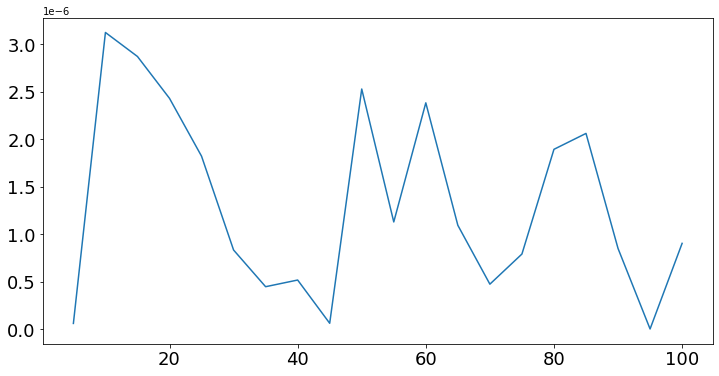

In [15]:
fontsize = 18
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(porcentajes,sigma_array)
ax.xaxis.set_tick_params(labelsize=fontsize)
ax.yaxis.set_tick_params(labelsize=fontsize)


In [26]:
import h5py
str_name_hdf5 = 'realizationNum=%d-sigma-vs-percentage-undersampling-pos-db2-arrays-snr=%d-db.hdf5' % (numRealizations,SNR_dB)
print(str_name_hdf5)
h5f = h5py.File(str_name_hdf5,'w')
h5f.create_dataset('percentage', data=percentages)
h5f.create_dataset('sigma', data=sigma_array)
#h5f.close()

realizationNum=3-sigma-vs-percentage-undersampling-pos-db2-arrays-snr=40-db.hdf5


OSError: Unable to create file (unable to truncate a file which is already open)

In [19]:
h5f.keys()

<KeysViewHDF5 ['percentage', 'sigma']>

In [20]:
h5f = h5py.File(str_name_hdf5,'r')

In [24]:
np.array(h5f['percentage'])

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [25]:
np.array(h5f['sigma'])

array([6.37814349e-08, 3.12198501e-06, 2.86942733e-06, 2.42953251e-06,
       1.82151070e-06, 8.35489089e-07, 4.49740454e-07, 5.19978261e-07,
       6.54271069e-08, 2.52759422e-06, 1.13045303e-06, 2.38230516e-06,
       1.09517904e-06, 4.76493769e-07, 7.93135056e-07, 1.89383790e-06,
       2.06096067e-06, 8.51686245e-07, 5.49526136e-09, 9.05468336e-07])